# Lane detection

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob
from FeaturesConfig import *
from Common import *
from FindCars import *
from StableCars import *
from Train import *

20:56:51 INFO Common initializing
20:56:51 INFO FindCars initializing
20:56:51 INFO StableCars initializing
20:56:52 INFO Train initializing


## Train

In [6]:
cfg = FeaturesConfig()
train = Train(cfg, small=False, sample_size=0)
car_features, noncar_features = train.prepare_all_features()

19:07:11 INFO #vehicules: 8792 #nonVehicules: 8968
100%|██████████| 8968/8968 [01:39<00:00, 90.42it/s] 
19:10:21 INFO 190.15 Seconds to prepare features


In [7]:
train.train(car_features, noncar_features)

19:10:49 INFO Feature vector length: 8460
19:15:10 INFO 260.97 Seconds to fit model
19:15:11 INFO Test Accuracy of SVC = 0.98


## Process video 

In [2]:
svc = load_svc()
find = FindCars(svc['cfg'], svc['svc'], svc['scaler'], scales=[1.25])

In [ ]:
def make_samples(starts, length=1):
    stable = StableCars(find, threshold=20, last_n=10, alpha=0.9)
    for start in starts:
        clip = VideoFileClip("project_video.mp4")
        clip = clip.subclip(start, start+length)
        processed = clip.fl_image(stable.stablize)
        processed.write_videofile(('processed_video.{}.mp4').format(start), audio=False)
        
make_samples([1,10,20], length=2)
#make_samples([30,40,50], length=2)

In [10]:
stable = StableCars(find, threshold=20, last_n=10, alpha=0.9)
clip = VideoFileClip("project_video.mp4")
processed = clip.fl_image(stable.stablize)
processed.write_videofile('processed_video.2.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.2.mp4
[MoviePy] Writing video processed_video.2.mp4


100%|█████████▉| 1260/1261 [16:10<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.2.mp4 



## Visualize 

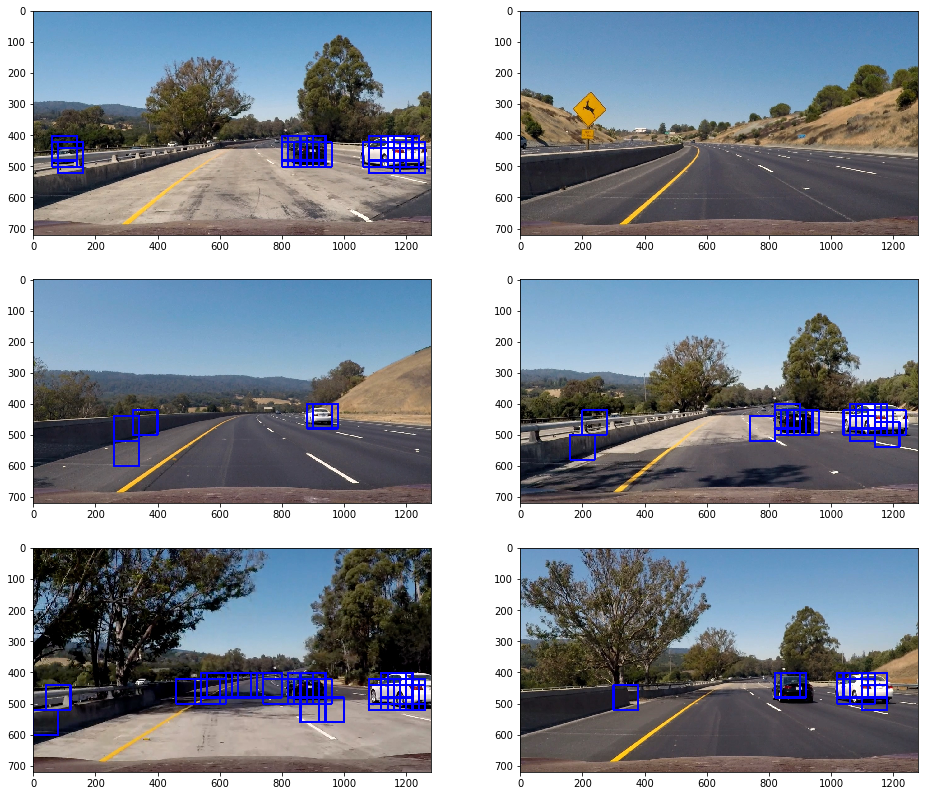

In [16]:
stable = StableCars(find, threshold=20, last_n=10, alpha=0.8)
fig = plt.figure(figsize=[16,14])
c = 1
for img in glob.glob('test_images/test*.jpg'):
    fig.add_subplot(3,2,c)
    c += 1
    img = mpimg.imread(img)
    img2 = find.draw_cars(img)
    plt.imshow(img2)

[MoviePy] >>>> Building video x.mp4
[MoviePy] Writing video x.mp4



 25%|██▌       | 13/51 [00:21<01:01,  1.61s/it]

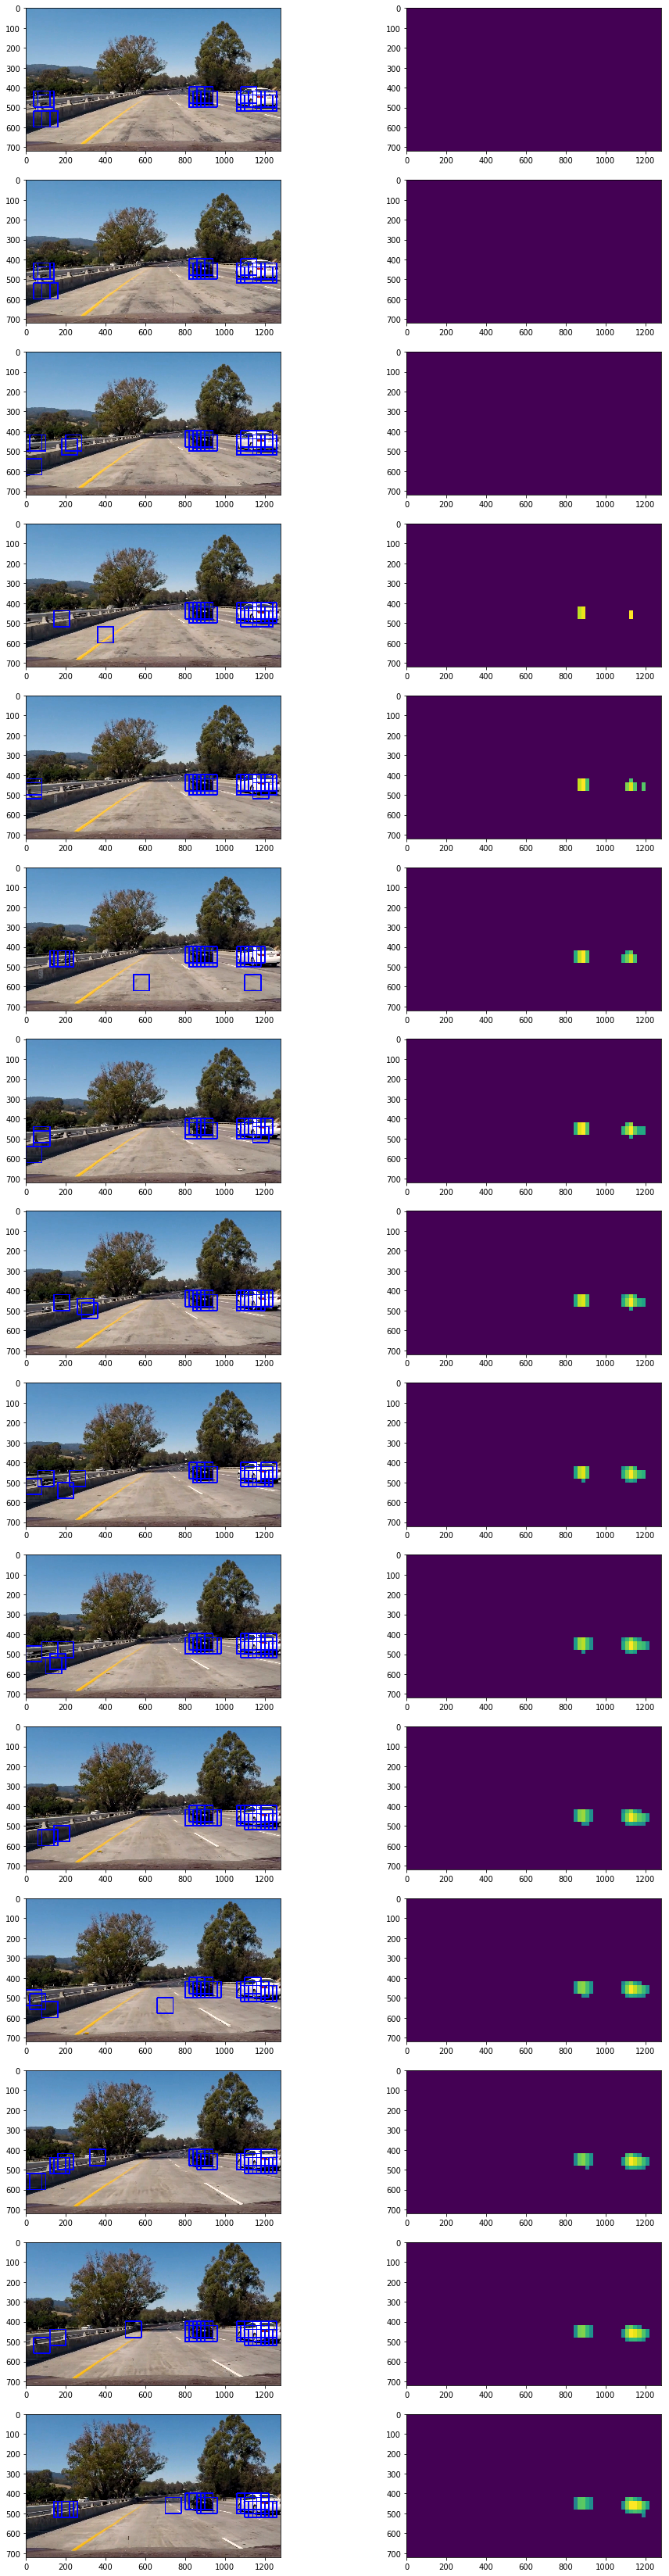

In [9]:
stable = StableCars(find, threshold=20, last_n=10, alpha=0.9)
fig = plt.figure(figsize=[16,60])

last_img = []
n = 15
c = 1
def process(img):
    global c
    global last_img
    last_img= stable.find.draw_cars(img)
    fig.add_subplot(n,2,c)
    plt.imshow(last_img)
    c += 1
    fig.add_subplot(n,2,c)
    stable.stablize(img)
    plt.imshow(stable.heat)
    c += 1
    if c>=2*n:
        raise EOFError
    return img

clip = VideoFileClip("project_video.mp4")
clip = clip.subclip(40,42)
processed = clip.fl_image(process)
try:
    processed.write_videofile('x.mp4', audio=False)
except EOFError:
    pass

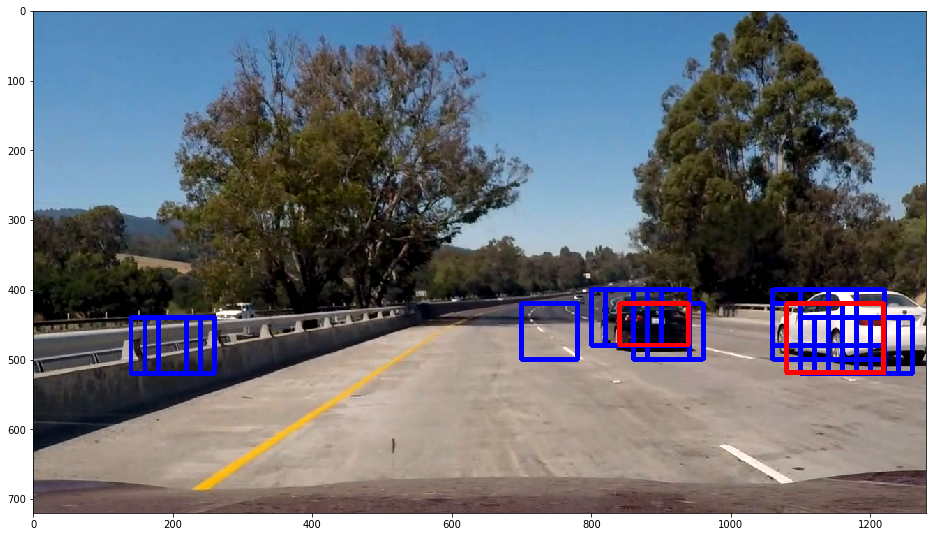

In [10]:
heat = np.copy(stable.heat)
labels = label(heat)
for car_number in range(1, labels[1] + 1):
    nonzero = (labels[0] == car_number).nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    cv2.rectangle(last_img, bbox[0], bbox[1], 255, 6)

plt.figure(figsize=[16,14])
plt.imshow(last_img)

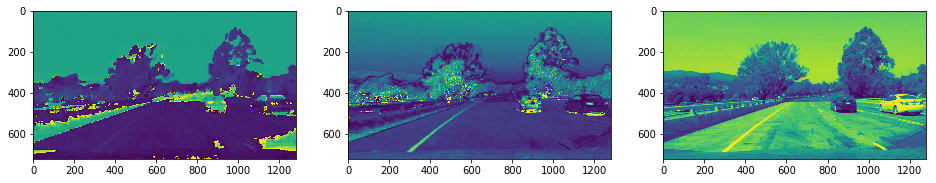

In [31]:
cfg = FeaturesConfig()
img = mpimg.imread('test_images/test1.jpg')
img = convert_color(img, cfg)
fig = plt.figure(figsize=[16,14])
for i in range(3):
    fig.add_subplot(1,3,i+1)
    plt.imshow(img[:,:,i])
#_,hog = get_hog_features(img[:,:,2], cfg.orient, cfg.pix_per_cell, cfg.cell_per_block, vis=True)

In [39]:
def show_hog(files):
    n=5
    fig = plt.figure(figsize=[16,30])
    i = 1
    for file in files:
        if i>n*4: break
        img = mpimg.imread(file)
        fig.add_subplot(n,4,i)
        plt.imshow(img)
        i += 1
        img = convert_color(img, cfg)
        for c in range(3):
            fig.add_subplot(n,4,i)
            _,hog = get_hog_features(img[:,:,c], cfg.orient, cfg.pix_per_cell, cfg.cell_per_block, vis=True)
            plt.imshow(hog, cmap='gray')
            i += 1

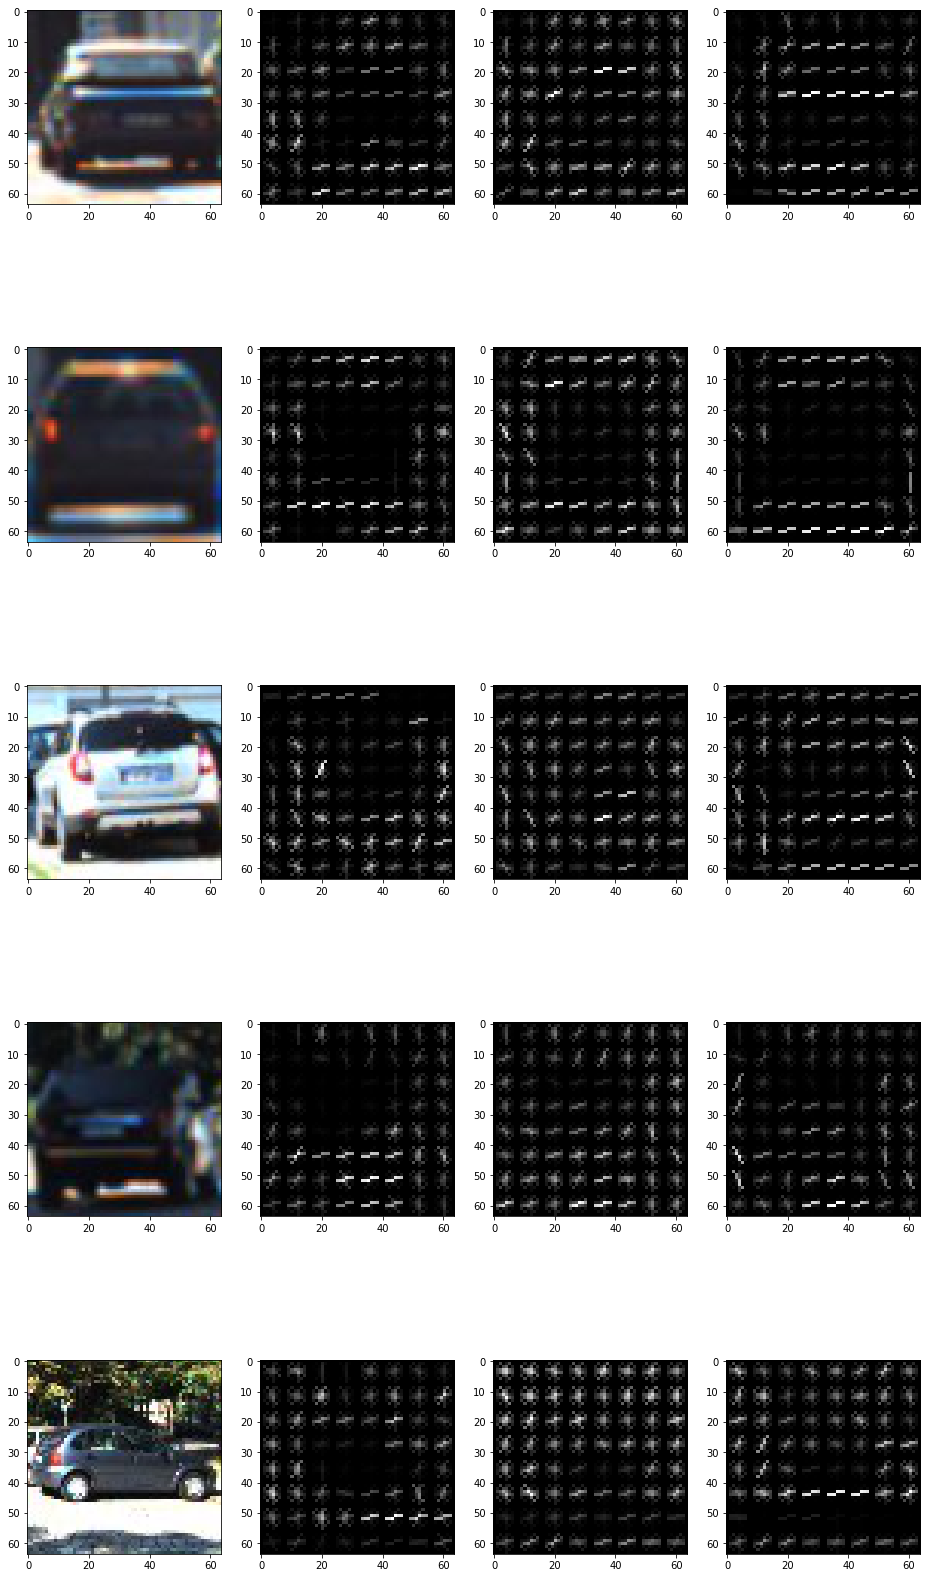

In [40]:
show_hog(glob.glob('vehicles_smallset/*/*.jpeg'))

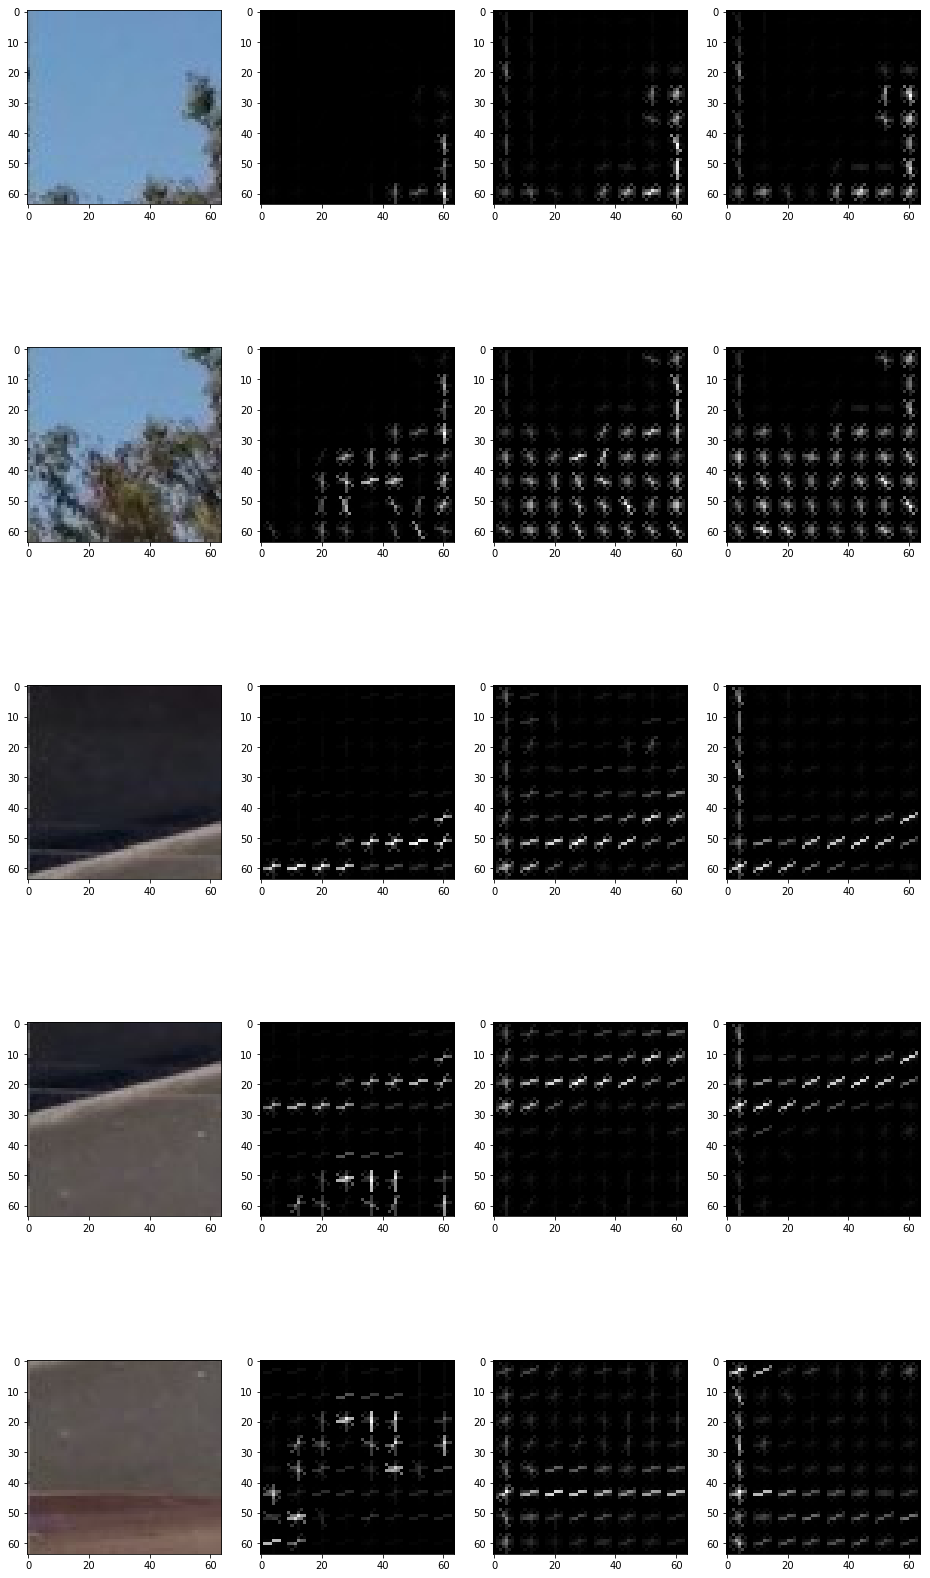

In [41]:
show_hog(glob.glob('non-vehicles_smallset//*/*.jpeg'))